# Sheet 10

Lynn Pauline Hansen, Jonathan Oel, Jannick Schulze, Elena Silvestre Roselló

## Problem 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Finely gridded true field
rho_m = np.loadtxt('data/density.txt')
delta_m = (rho_m - np.mean(rho_m))/np.mean(rho_m)

x = np.loadtxt('data/densityx.txt')
y = np.loadtxt('data/densityy.txt')

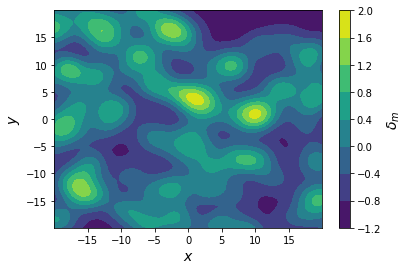

In [3]:
plt.contourf(x, y, delta_m)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
cbar = plt.colorbar()
cbar.set_label(r'$\delta_m$', fontsize=14)

(16641, 2)
29


Text(0, 0.5, 'Y[pix]')

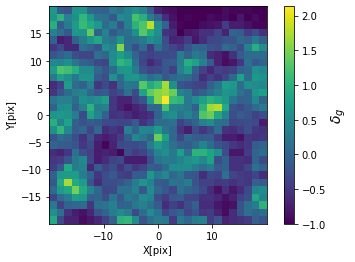

In [4]:
galaxies = np.loadtxt('data/catalog.txt')

print(np.shape(galaxies))

Ngal = np.shape(galaxies)[0]

#We want approximately 20 galaxies per pixel
Nbins = int(np.round(np.sqrt(Ngal/20)))

print(Nbins)


#bin_edges = np.array([np.linspace(-20.,20.,Nbins)

gal_grid, xedges, yedges = np.histogram2d( galaxies[:,0],galaxies[:,1], Nbins)

delta_g = (gal_grid - np.mean(gal_grid))/np.mean(gal_grid)


plt.imshow(delta_g.T, extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]])
cbar2 = plt.colorbar()
cbar2.set_label(r'$\delta_g$', fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel('X[pix]')
plt.ylabel('Y[pix]')

# Problem 2

## (i)

In [5]:
def Statistics_field (delta_g, gal_grid, Nbins, xedges, yedges, jack_grid = False):
    """ Computes the statistics variance, standard deviation, kurtosis and center of mass coordinates for a field of galaxies
    Input:
        delta_g (np.array(Nbin, Nbin), float): galaxy density contrast
        gal_grid (np.array(Nbin, Nbin), int): number of galaxies per bin
        xedges (np.array(Nbin+1), float): positions of the edges of the pixels in x coordinate
        yedges (np.array(Nbin+1), float): positions of the edges of the pixels in y coordinate
        jack_grid (bool): True if the statistics are computed for jackknifing on grid level (see problem 3.1)
    Returns:
        dg_var (float): variance of the density contrast
        dg_std (float): std of the density contrast
        gamma2 (float): kurtosis of the density contrast
        dg_com_x, dg_com_y (float, float): x and y coordinates of the center of mass
    """
    #Variance of the overdensity field
    dg_mean = np.mean(delta_g)
    Npix = Nbins**2
    dg_var = 1/(Npix-1)*np.sum((delta_g-dg_mean)**2)

    #Standard deviation
    dg_std = np.sqrt(dg_var)

    #Kurtosis
    #4th central moment
    mu_4 = 1/(Npix-1)*np.sum((delta_g-dg_mean)**4)
    #This is a biased estimate, but given in the question
    gamma2 = mu_4/dg_var**2 -3
    
    #Center of mass
    if jack_grid:
        #Cannot compute it without biasing the result towards 0
        dg_com_x = []
        dg_com_y = []
    else:
        #Positions on grid 
        positions_x, positions_y = np.meshgrid((xedges[1:]+xedges[:-1])/2,(yedges[1:]+yedges[:-1])/2)
        dg_com_x = np.sum((gal_grid*positions_x))/np.sum(gal_grid)
        dg_com_y = np.sum((gal_grid*positions_y))/np.sum(gal_grid)

    return dg_var, dg_std, gamma2,dg_com_x, dg_com_y
    
dg_var, dg_std, gamma2,dg_com_x, dg_com_y = Statistics_field(delta_g, gal_grid, Nbins, xedges, yedges)

#To check biases later
parameters_wholesample = np.array([dg_var, dg_std, gamma2,dg_com_x, dg_com_y])

print('Variance:')
print(dg_var)

print('Standard deviation:')
print(dg_std)

print('Kurtosis (gamma2):')
print(gamma2)

print('Center of mass [x,y]:')
print(dg_com_x, dg_com_y)

Variance:
0.3108880433170473
Standard deviation:
0.5575733524093913
Kurtosis (gamma2):
0.18139532808706482
Center of mass [x,y]:
0.2218764394667512 -1.38498282155547


## (ii)

In [6]:
#Repeat for a few number of bins

var = []
kurtosis = []
std = []
x_cm = []
y_cm = []

for Nbin in range(5, 1000, 10): #These are pixels on each direction
    
    gal_gridn, xedgesn, yedgesn = np.histogram2d( galaxies[:,0],galaxies[:,1], Nbin)
    delta_gn = (gal_gridn - np.mean(gal_gridn))/np.mean(gal_gridn)
    varn, stdn, kurtn ,x_cmn, y_cmn = Statistics_field (delta_gn, gal_gridn, Nbin, xedgesn, yedgesn)

    var.append(varn)
    kurtosis.append(kurtn)
    std.append(stdn)
    x_cm.append(x_cmn)
    y_cm.append(y_cmn)


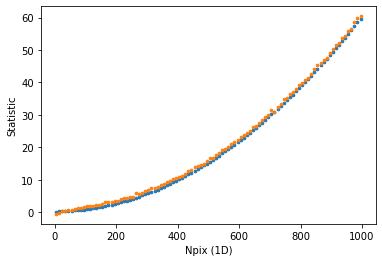

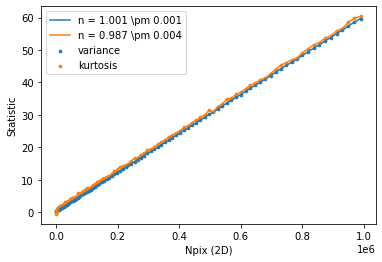

In [7]:
#Plot 1D
Npix = np.arange(5, 1000, 10)
plt.scatter(Npix, var, label='variance', s=7)
plt.scatter(Npix, kurtosis, label='kurtosis', s=7)
plt.xlabel('Npix (1D)')
plt.ylabel('Statistic')
plt.show()

#Plot 2D
plt.clf()
plt.scatter(Npix**2, var, label='variance', s=7)
plt.scatter(Npix**2, kurtosis, label='kurtosis', s=7)
plt.xlabel('Npix (2D)')
plt.ylabel('Statistic')

#Fit a power law to the number of pixels
def fitting_power(Npix, A, n, C):
    """Fitting power for variance of kurtosis.
    Input:
        Npix (int): TOTAL number of pixels 
        A (float): amplitude
        n(float): index
        C(index): additive constant
    Return:
        power (float)
    """
    return A*Npix**n + C

import scipy.optimize as so
for statistic in [var, kurtosis]:
    popt, pcov = so.curve_fit(fitting_power, Npix**2, statistic)
    #Plot the fit
    plt.plot(Npix**2, statistic, label= f'n = {popt[1]:.3f} \pm {np.sqrt(pcov[1,1]):.3f}')
    
plt.legend()

If there are more pixels there is on average less galaxies per pixel, which increases the uncertainty (makes the field less uniform). The distribution of galaxies in a lot of pixels results in shot noise, where the uncertainty is proportional to $\sqrt{N}$.

If we look at the variance we expect it to grow as $s^2 \propto \sqrt{N}^2 = N$. This can be seen in the fit $s^2 = A N_{pix}^n +C$, where we obtain $n= 1.001 \pm 0.001$.

If we look at the kurtosis, $ \gamma_2 = \beta_2 -3 = \mu_4 /\sigma^4 -3$ we find as well $n= 0.987 \pm 0.004$, where the discrepancy with 1 seems to come from a higher variability at low pixels. This hints that $\mu_4\propto N^2$. The fast growth of $\gamma_2$ (which is around 0 for a Gaussian distribution) is expected from the low densities, since the central limit theorem states that a Gaussian distribution is a good distribution only for densities of the order of 10.

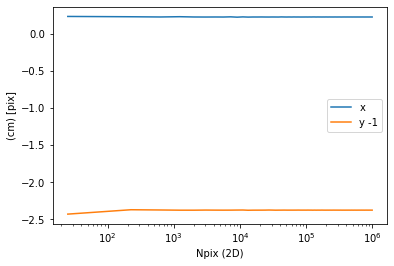

In [8]:
#Study on the center of mass

plt.plot(Npix**2, x_cm, label='x')
plt.plot(Npix**2, np.array(y_cm) -1, label='y -1')
plt.xlabel('Npix (2D)')
plt.ylabel('(cm) [pix]')
plt.xscale('log')
plt.legend()

If we look at the center of mass we find that it oscillates a lot when there are a few pixels but tends to a value when the number of pixels increases. 

For low number of pixels the grid of positions plays a very important role. The moment that the number of pixels is of the same order as the number of galaxies the pixellized positions are almost the same as the discrete positions, so the center of mass is around its true value. In order to solve this problem for low number of pixels one could use for example a could in cell method in the galaxy distribution.



# Problem 3: error estimation

## (i) and (ii)

Start first with Jackknife, both in galaxy level and pixel level

In [9]:
def JK_error (gal, param_wholesample, grid_level = False):
    """ Computes an estimate of the uncertainty with the jackknifing method for the parameters variance, kurtosis, std, x_cm and y_cm.
    Input:
        gal (np.array(2,Ngal), float): positions of the galaxies
        grid_level (bool): True is the jackknifing is done on a grid level
    Returns:
        mean_param (np.array(Nparam), float): average value of the parameters over the different subsamples. The center of mass not computed if grid_level chosen
        e_param: uncertainty of the parameters
    """

    Ngal = np.shape(gal)[0]
    Nbin = 29 #to ensure around 20 galaxies /pixel
    
    if grid_level:
        Nsamples = Nbin**2 #Take out one pixel at a time
    else:
        Nsamples = Ngal #Take out one galaxy at a time
    
    #Parameters we are interested in
    var = np.zeros(Nsamples)
    kurtosis = np.zeros(Nsamples)
    std = np.zeros(Nsamples)
    x_cm = np.zeros(Nsamples)
    y_cm = np.zeros(Nsamples)

   
    if grid_level:
        gal_grid, xedges, yedges = np.histogram2d( gal[:,0],gal[:,1], Nbin)
        delta_g = (gal_grid - np.mean(gal_grid))/np.mean(gal_grid)
        #Flatten the array, doesn't influence var, std or kurtosis
        flatten_delta = delta_g.flatten()
        print('Center of mass cannot be computed on a grid')
        for i in range(Nbin*Nbin):
            jgrid = np.delete(flatten_delta, i)
            var[i], std[i], kurtosis[i] ,_, _ = Statistics_field (jgrid, gal_grid, Nbin, xedges, yedges, True) #The true stands for Jacknifing on grid
            
    else: #Galaxy level
        for i in range(Ngal):
            #Get the subsamples
            subsample = np.delete(gal, i, axis=0)

            gal_grid, xedges, yedges = np.histogram2d( subsample[:,0],subsample[:,1], Nbin)
            delta_g = (gal_grid - np.mean(gal_grid))/np.mean(gal_grid)
            var[i], std[i], kurtosis[i] ,x_cm[i], y_cm[i] = Statistics_field (delta_g, gal_grid, Nbin, xedges, yedges, False)#The false stands for Jacknifing on galaxies

    #Estimate of the error on every parameter estimation
    mean_param = np.zeros(5)
    e_param = np.zeros(5)
    bias = np.zeros(5)
    bias_corrected_param = np.zeros(5)
    for i,parameter in enumerate([var, std, kurtosis, x_cm, y_cm]):
        mean_param[i] = 1/(Nsamples)*np.sum(parameter)
        e_param[i] = ((Nsamples-1)/Nsamples *np.sum((parameter-mean_param[i])**2))**(0.5)
        bias[i] = (Nsamples-1)*(mean_param[i]-param_wholesample[i])
        bias_corrected_param[i] = param_wholesample[i] - bias[i]
        
    return bias_corrected_param, e_param, bias


In [10]:
#Jacknifing on galaxy level
bias_corrected_param, e_param, bJ = JK_error(galaxies, parameters_wholesample)

print('var, std, gamma2, x_cm, y_cm:')
print(bias_corrected_param)
print('With errors:')
print(e_param)
print('Bias:')
print(bJ)


var, std, gamma2, x_cm, y_cm:
[ 0.26045708  0.51240276  0.0071017   0.22253522 -1.38557157]
With errors:
[0.00856526 0.00768101 0.2413815  0.08556279 0.08827028]
Bias:
[ 0.05043096  0.04517059  0.17429363 -0.00065878  0.00058875]


If we compare with the results from 2.1

Variance:
0.3108880433170473

Kurtosis (gamma2):
0.18139532808706482

Standard deviation:
0.5575733524093913

Center of mass [x,y]:
0.2218764394667512 1.3720205924261497

we find that the estimates of the parameters are similar as the case without jackknifing and most importantly they are compatible within the errors.

In [11]:
#Jacknifing on pixel- level

bias_corrected_param_grid, e_param_grid, bJ_grid = JK_error(galaxies, parameters_wholesample, True)

print('var, std, gamma2, x_cm, y_cm:')
print(bias_corrected_param_grid)
print('With errors:')
print(e_param_grid)
print('Bias:')
print(bJ_grid)

Center of mass cannot be computed on a grid
var, std, gamma2, x_cm, y_cm:
[ 6.21776087e-01  8.36625260e-01 -2.98861343e+00  1.86598086e+02
 -1.16477055e+03]
With errors:
[0.01585653 0.01425023 0.21747622 0.         0.        ]
Bias:
[-3.10888043e-01 -2.79051907e-01  3.17000876e+00 -1.86376209e+02
  1.16338557e+03]


We find again that the results are compatible with the ones that used all pixels within the uncertainty. 

Since the number of different subsamples is much smaller ($30^2$ instead of $16\times 10^4$) the error estimates are also bigger.

The estimate of the center of mass could be computed by not using the flattened array by masking every pixel one by one. However, this was not done here.

In general we find that the kurtosis estimate is the worst one  and the standard deviation one the best.


### Bootstrap

In [ ]:
def Bootstrap_error (gal, param_wholesample):
    """ Computes an estimate of the uncertainty with the bootstrap method for the parameters variance, kurtosis, std, x_cm and y_cm.
    Input:
        gal (np.array(2,Ngal), float): positions of the galaxies
    Returns:
        mean_param (np.array(Nparam), float): average value of the parameters over the different subsamples. The center of mass not computed if grid_level chosen
        e_param: uncertainty of the parameters
    """
    #Specify information
    Ngal = np.shape(gal)[0]
    Nsamples = 30**2 #For easy comparison with the Jackknife non grid method
    Nbin = 29
    
    #Parameters we are interested in
    var = np.zeros(Nsamples)
    kurtosis = np.zeros(Nsamples)
    std = np.zeros(Nsamples)
    x_cm = np.zeros(Nsamples)
    y_cm = np.zeros(Nsamples)
    
    #Compute samples and their parameter values
    for i in range(Nsamples):
        #Draw Ngal integers between 0 and Ngal (last not inlcuded) from a discrete unifrom distribution
        indices = np.random.randint(low=0, high=Ngal, size=Ngal, dtype=np.int64)
        sample = gal[indices]
        
        gal_grid, xedges, yedges = np.histogram2d( sample[:,0],sample[:,1], Nbin)
        delta_g = (gal_grid - np.mean(gal_grid))/np.mean(gal_grid)
        var[i], std[i], kurtosis[i] ,x_cm[i], y_cm[i] = Statistics_field (delta_g, gal_grid, Nbin, xedges, yedges, False)
        
    #Estimate of the error on every parameter estimation
    mean_param = np.zeros(5)
    e_param = np.zeros(5)
    bias = np.zeros(5)
    unbiased_param = np.zeros(5)
    for i,parameter in enumerate([var, std, kurtosis,x_cm, y_cm]):
        mean_param[i] = 1/(Nsamples)*np.sum(parameter)
        e_param[i] = (1/(Nsamples-1) *np.sum((parameter-mean_param[i])**2))**(0.5)
        bias[i] = 1/Nsamples*np.sum(parameter-param_wholesample[i])
        unbiased_param[i] = 2*param_wholesample[i]-mean_param[i]
        
    return unbiased_param, e_param, bias


In [13]:
mean_param_B, e_param_B, bB = Bootstrap_error(galaxies, parameters_wholesample)

print('var,  std, gamma2, x_cm, y_cm:')
print(mean_param_B)
print('With errors:')
print(e_param_B)
print('Bias:')
print(bB)

var,  std, gamma2, x_cm, y_cm:
[ 0.26048677  0.51411836 -0.02476663  0.22583915 -1.38492713]
With errors:
[0.00886252 0.00736943 0.25051281 0.08415862 0.09316394]
Bias:
[ 5.04012747e-02  4.34549912e-02  2.06161956e-01 -3.96270621e-03
 -5.56881721e-05]


Variance, std. and the center of mass from the Jackknife method on galaxy level and the bootstrap method are in very good agreement with each other. The estimator of the kurtosis has in both cases the largest uncertainty of all parameters and the values from both methods are compatible within these errors.

Because the results from both methods are consistent with each other, we can say that the statistics of this problem are smooth enough for the Jackknife method to apply here, meaning that small changes in the data only cause small changes in the estimator. Since the Jackknife method is a linear approximation of the bootstrap method, we are well in that linear regime of the bootstrap method.